# Use Variational Autoencoder to generate the distribution
2. Deep Learning Models: VAE, Diffusion Model, Self-attention, and Transformer

### Import libraries

In [1]:
import numpy as np
from PIL import Image
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from tqdm import tqdm
from torch import Tensor
import math
import matplotlib.pyplot as plt

### Define the model architecture using variational autoencoder 

In [2]:
# Define the model architecture using variational autoencoder 
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, nhead=4, dropout=0.1, num_layers=2):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            # nn.ReLU()
        )
        
    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        z = self.decoder(z)
        return z
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar
    
    def loss_function(self, x, x_hat, mu, logvar):
        BCE = F.binary_cross_entropy(x_hat[:, 2:], x[:, 2:], reduction='sum')
        MSE = F.mse_loss(x_hat, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return 1.0 * MSE + 0.01 * KLD + 0.0 * BCE

### Define the dataset and dataloader
- I use Dataset, Dataloader from torch.utils.data and build customize ColoredPiDataset, and normalize data points to [0, 1] or [-1, 1]:

In [3]:
# Define the dataset and dataloader
class ColoredPiDataset(Dataset):
    def __init__(self, image_path, xs_path, ys_path):
        self.xs = np.load(xs_path)
        self.ys = np.load(ys_path)
        self.image_array = np.array(Image.open(image_path))
        self.rgb_values = self.image_array[self.xs, self.ys]
        
        # Normalize xy values to be between 0 and 1
        self.xs, self.ys = self.xs / 299.0, self.ys / 299.0

        # Normalize rgb values to be between 0 and 1
        self.rgb_values = self.rgb_values / 255.0
        
        # # Normalize xy values to be between -1 and 1
        # self.xs, self.ys = (self.xs / 149.5) - 1.0, (self.ys / 149.5) - 1.0
        
        # # Normalize rgb values to be between -1 and 1
        # self.rgb_values = (self.rgb_values / 127.5) - 1.0

    def __len__(self):
        return len(self.xs)
        # return 30000

    def __getitem__(self, idx):
        if idx >= 5000:
            return torch.zeros((5)).to(torch.float32)
        return torch.tensor([self.xs[idx], self.ys[idx], self.rgb_values[idx][0], self.rgb_values[idx][1], self.rgb_values[idx][2]]).to(torch.float32)

### Define training function
- Then, I build training function to conduct back-propagation in each epoch. Here we take the VAE training function as example.


In [4]:
# Define training function
def train_vae(model, optimizer, criterion, dataloader, device):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        noise = torch.randn(batch.shape[0], 5).to(device)
        recon_batch, mu, logvar = model(batch)

        loss = model.loss_function(batch, recon_batch, mu, logvar)

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

### Training
- Here I perform the training function and set the training parameters. I use tqdm to watch the training procedue. (we take VAE as example)

In [5]:
# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define hyperparameters
input_dim = 5 # XYRGB values
hidden_dim = 128
latent_dim = 16
num_layers = 2
num_heads = 4
dropout = 0.1

batch_size = 128
learning_rate = 3e-4
num_epochs = 600
num_samples = 500

# Load the dataset
dataset = ColoredPiDataset('sparse_pi_colored.jpg', 'pi_xs.npy', 'pi_ys.npy')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Initialize model, optimizer, and loss function
# model = ColoredPiGenerator().to(device)
# model = ColoredPiGenerator(num_points=batch_size).to(device)
# model = ColoredPiGenerator(input_dim, hidden_dim, num_layers, num_heads, dropout).to(device)
model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Train model
iteration = tqdm(range(num_epochs))
for epoch in iteration:
    train_loss = train_vae(model, optimizer, criterion, dataloader, device)
    iteration.set_description('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss))

Epoch [600/600], Train Loss: 4.9205: 100%|██████████| 600/600 [02:39<00:00,  3.76it/s]


### Generate some samples from the model
- Finally, I performed the visualisation to see how the the distribution of model looks like by sampling the noise from gaussian distribution. I genrated the generated_image with the same shape of image_array. Also, I sample same number of points by iterating through the batchs in one epoch.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


xy mean: 146.24825687209764, xy std: 60.668534393933385, xy max: 283.2167053222656, xy min: 29.956466674804688
rgb mean: 152.831613394185, rgb std: 39.12975733865424, rgb max: 234.9546356201172, rgb min: 43.33704376220703
Error: 15.188425925925927


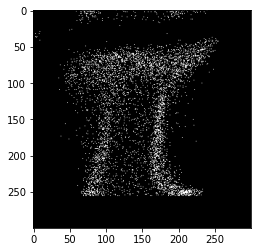

In [8]:
# Generate some samples from the model
generated_image = np.zeros(dataset.image_array.shape)
xy  = np.zeros((len(dataloader)*batch_size, 2))
rgb = np.zeros((len(dataloader)*batch_size, 3))
for sample_idx, batch in enumerate(dataloader):
    with torch.no_grad():
        samples = model.decode(torch.randn(batch_size, latent_dim).to(device))

        # Denomarlizing samples
        # samples[:, :2] = (samples[:, :2] + 1) * 149.5
        samples[:, :2] = torch.clip(samples[:, :2], 0, 1) * 299
        
        # Denomarlizing samples
        # samples[:, 2:] = (samples[:, 2:] + 1) * 127.5
        samples[:, 2:] = torch.clip(samples[:, 2:], 0, 1) * 255
        
        xy[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, :2].cpu().numpy()
        rgb[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, 2:].cpu().numpy()

        samples = samples.cpu().numpy().astype(np.uint8)
        for i in range(batch_size):
            x, y, r, g, b = samples[i]
            generated_image[x, y] = [r, g, b]
            
print(f'xy mean: {np.mean(xy)}, xy std: {np.std(xy)}, xy max: {np.max(xy)}, xy min: {np.min(xy)}')
print(f'rgb mean: {np.mean(rgb)}, rgb std: {np.std(rgb)}, rgb max: {np.max(rgb)}, rgb min: {np.min(rgb)}')
print(f'Error: {np.mean(np.abs(generated_image - dataset.image_array))}')

# Save the output image
# Image.fromarray(generated_image).save('generated_pi_colored.jpg')
plt.imshow(generated_image, cmap='gray')

### Generate some samples from the model


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


xy mean: 145.20052051563295, xy std: 61.0882097193814, xy max: 282.5466003417969, xy min: 29.24165153503418
rgb mean: 153.64406541983286, rgb std: 39.44389842555231, rgb max: 235.80223083496094, rgb min: 40.315155029296875
Error: 15.39558888888889


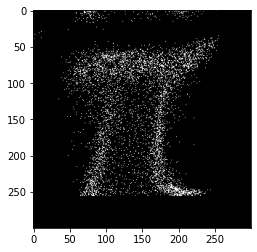

In [9]:
# Generate some samples from the model
generated_image = np.zeros(dataset.image_array.shape)
xy  = np.zeros((len(dataloader)*batch_size, 2))
rgb = np.zeros((len(dataloader)*batch_size, 3))
for sample_idx, batch in enumerate(dataloader):
    with torch.no_grad():
        samples = model.decode(torch.randn(batch_size, latent_dim).to(device))

        # Denomarlizing samples
        # samples[:, :2] = (samples[:, :2] + 1) * 149.5
        samples[:, :2] = torch.clip(samples[:, :2], 0, 1) * 299
        
        # Denomarlizing samples
        # samples[:, 2:] = (samples[:, 2:] + 1) * 127.5
        samples[:, 2:] = torch.clip(samples[:, 2:], 0, 1) * 255
        
        xy[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, :2].cpu().numpy()
        rgb[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, 2:].cpu().numpy()

        samples = samples.cpu().numpy().astype(np.uint8)
        for i in range(batch_size):
            x, y, r, g, b = samples[i]
            generated_image[x, y] = [r, g, b]
            
print(f'xy mean: {np.mean(xy)}, xy std: {np.std(xy)}, xy max: {np.max(xy)}, xy min: {np.min(xy)}')
print(f'rgb mean: {np.mean(rgb)}, rgb std: {np.std(rgb)}, rgb max: {np.max(rgb)}, rgb min: {np.min(rgb)}')
print(f'Error: {np.mean(np.abs(generated_image - dataset.image_array))}')

# Save the output image
# Image.fromarray(generated_image).save('generated_pi_colored.jpg')
plt.imshow(generated_image, cmap='gray')